# Visualizing an AsyncResult in progress

In [1]:
import ipyparallel as ipp

In [2]:
cluster = ipp.Cluster()
n = 8
await cluster.start_cluster(8)
rc = await cluster.connect_client()
rc.wait_for_engines(n)

Using existing profile dir: '/Users/minrk/.ipython/profile_default'
Sending output for ipcontroller-touchy-1628258116-xwps-77061 to /Users/minrk/.ipython/profile_default/log/ipcontroller-touchy-1628258116-xwps-77061.log
Starting 8 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
Sending output for 0 to /Users/minrk/.ipython/profile_default/log/ipengine-touchy-1628258116-xwps-1628258117-mpma-0.log
Sending output for 1 to /Users/minrk/.ipython/profile_default/log/ipengine-touchy-1628258116-xwps-1628258117-mpma-1.log
Sending output for 2 to /Users/minrk/.ipython/profile_default/log/ipengine-touchy-1628258116-xwps-1628258117-mpma-2.log
Sending output for 3 to /Users/minrk/.ipython/profile_default/log/ipengine-touchy-1628258116-xwps-1628258117-mpma-3.log
Sending output for 4 to /Users/minrk/.ipython/profile_default/log/ipengine-touchy-1628258116-xwps-1628258117-mpma-4.log
Sending output for 5 to /Users/minrk/.ipython/profile_default/log/ipengine-touchy-1628258116-x

  0%|          | 0/8 [00:00<?, ?engine/s]

IPython Parallel tracks states of engines:

In [3]:
import datetime
import random


v = rc.load_balanced_view()


def work(t):
    import time

    time.sleep(t)
    return t


random.seed(1)
times = [0.1 + 0.1 * random.random() for i in range(256)]

start_time = datetime.datetime.now(datetime.timezone.utc)
ar = v.map_async(work, times)
ar.wait_interactive()

work:   0%|          | 0/256 [00:00<?, ?tasks/s]

We can view a summary of our performance efficiency
by comparing the 'wall time' (total time it took to compute the whole task and retrieve all results)
to the 'serial time' (total work time of all tasks on the engines)

The parallel 'efficiency' is the ratio of the speedup to the number of engines

In [4]:
wall_time = ar.wall_time
serial_time = ar.serial_time
speedup = serial_time / wall_time
n_engines = len(set(ar.engine_id))
efficiency = speedup / n_engines

print(f"wall time  : {wall_time:6.1f}s")
print(f"Serial time: {serial_time:6.1f}s")
print(f"Speedup    : {speedup:6.1f}x / {n_engines}")
print(f"Efficiency : {efficiency:7.1%}")

wall time  :    5.6s
Serial time:   39.7s
Speedup    :    7.1x / 8
Efficiency :   88.9%


We can collect the four timestamps and convert them to seconds since first submission,
and store these in a DataFrame for easier analysis

- 'submitted' is when the message is created on the client to be sent to the engines
- 'started' is when it arrived on the engine and began processing
- 'completed' is when it completed on the engine
- 'received' is when the result arrived back on the client


In [5]:
import pandas as pd
import datetime

data = {
    "engine_id": ar.engine_id,
}

for name in ("submitted", "started", "completed", "received"):
    data[name] = [(dt - start_time).total_seconds() for dt in ar[name]]


df = pd.DataFrame(data)
df['prepare'] = df['submitted'] - df['submitted'].min()
df['schedule'] = df['started'] - df['submitted']
df['compute'] = df['completed'] - df['started']
df['reply'] = df['received'] - df['completed']


Text(0, 0.5, 'tasks')

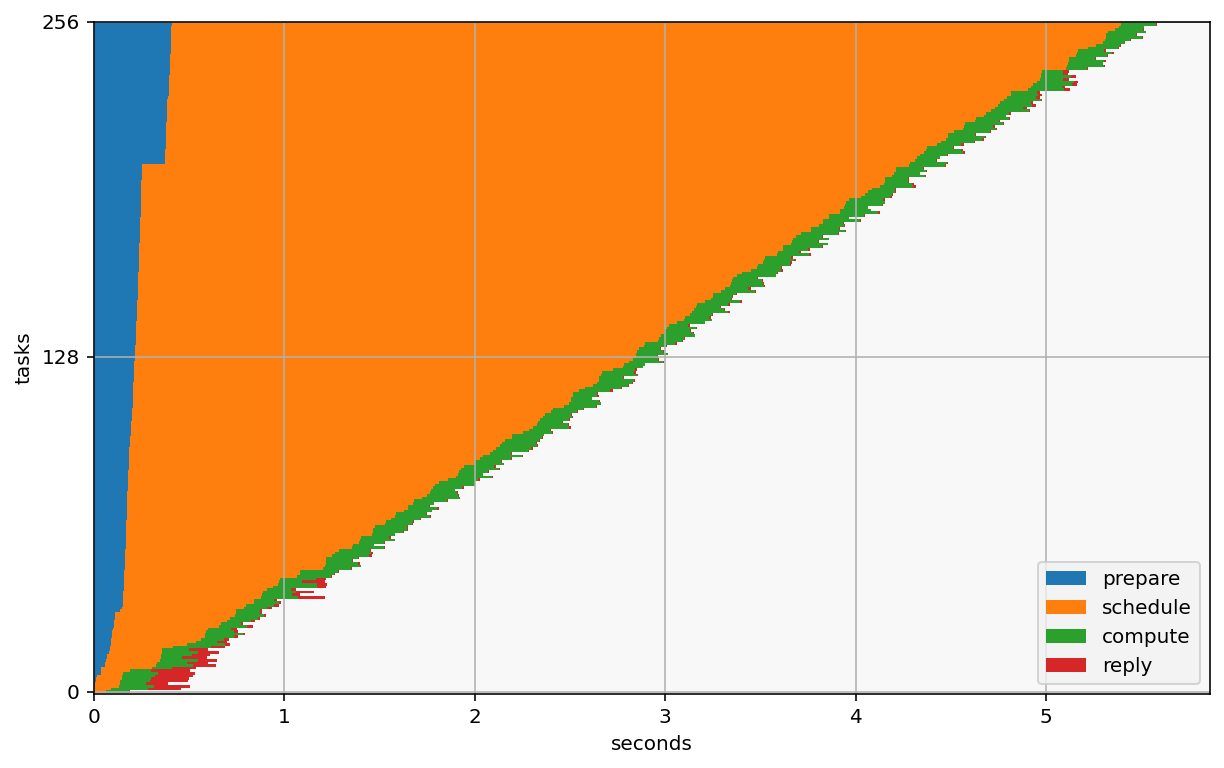

In [6]:
from matplotlib import pyplot as plt

df.plot.barh(y=['prepare', 'schedule', 'compute', 'reply'], stacked=True, width=1)
plt.grid((True, False))
yticks = [0, len(df) // 2, len(df)]
plt.yticks(yticks, yticks);
plt.xlabel("seconds")
plt.ylabel("tasks")
# plt.ylim([0, len(df)])

In this visualization, the blue indicates the time spent in the client preparing the tasks to be submitted.
It takes 200ms to prepare and send all of these mesages.

The blue area is mostly pure overhead of IPython parallel,
and should be minimized. The same goes for red, which is the same thing, just in the other direction - delivering completed results from engines to the client.

The orange indicates scheduling time - the time tasks are waiting in queues before starting.
There are two contributors to this:

1. available compute (if there are more tasks than engines, tasks need to wait). Allocating more engines can help with this.
   The optimal scenario here is one engine per task, which would mean no task ever has to wait for busy engines.
   On the other hand, your engines will probably spend a lot of time idle, so that's lost of wasted resources.
2. Scheduler overhead - There's always a cost to delivering messages.
   There is currently no separate measure of when a task has been *assigned* to an engine,
   so it is difficult to measure this one except by comparing the time between completing one task and starting the next
   
The green is time spent actually working on tasks. This is all the 'real' work. In a perfect world, the graph would be all green, but that's never going to happen.

The little bits of red are the overhead of delivering results back to the client.
That cost is usually very low.

We can also visualize the work on the engines,
which should look like a solid block of color if there's no wasted time.

The left and right edges are the times when the first task was created and the last result was received at the client (the total effective computation time).

The y axis is the engine id, and the x axis is time since the beginning of the task.
Space in the graph indicates idle engines.

Text(0, 0.5, 'engine id')

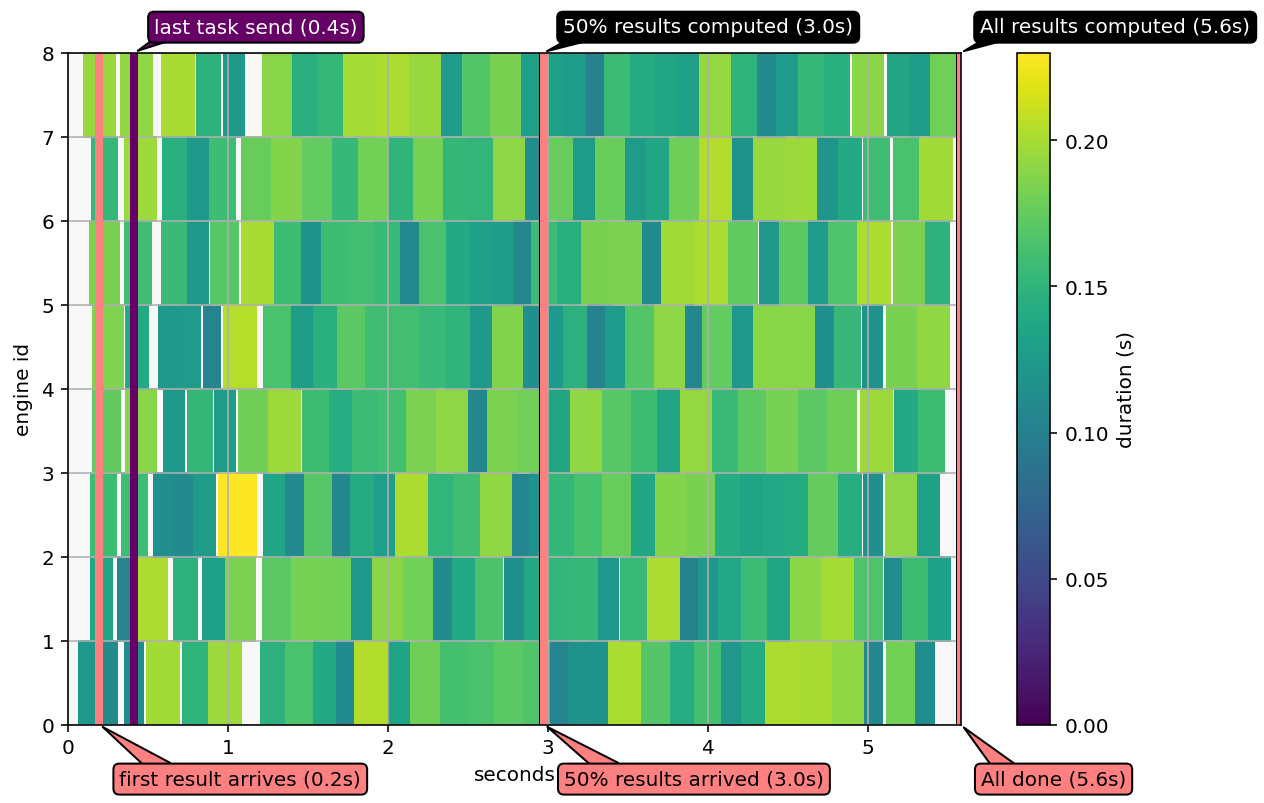

In [7]:
y = df.engine_id
x = df.started
width = df.completed
height = np.ones(len(df))

import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib import cm

color_map = mpl.cm.ScalarMappable(
    norm=mpl.colors.Normalize(vmin=0, vmax=df.compute.max()),
    cmap=cm.viridis,
)

plt.colorbar(color_map, label="duration (s)")


def working_rect(row):
    """Create a rectangle representing one task

    x = start time
    y = engine id
    width = duration
    height = 1
    color = duration
    """
    duration = row.completed - row.started
    return Rectangle(
        (row.started, row.engine_id),
        width=duration,
        height=1,
        color=color_map.to_rgba(duration),
    )


rects = df.apply(working_rect, axis=1)
pc = PatchCollection(rects, match_original=True)

ax = plt.gca()
ax.set_ylim(0, df.engine_id.max() + 1)
ax.set_xlim(0, df.received.max())
ax.add_collection(pc)

last_send = df.submitted.max()
finished = df.received.max()
first_result = df.received.min()
half_done = df.received.quantile(0.5)

ymin, ymax = ax.get_ylim()


def annotate_milestone(ax, t, label, color="red", dark=False, top=True):
    """Add a vertical line annotation for a milestone time"""

    patch = plt.vlines(
        [t],
        *ax.get_ylim(),
        linewidth=4,
        color=color,
    )
    if top:
        xy = (t, ymax)
        xytext = (10, 10)
    else:
        xy = (t, ymin)
        xytext = (10, -30)
    full_label = f"{label} ({t:.1f}s)"
    ax.annotate(
        full_label,
        xy=xy,
        xytext=xytext,
        textcoords="offset points",
        color="white" if dark else "black",
        bbox=dict(
            boxstyle="round",
            fc=color,
        ),
        arrowprops=dict(
            arrowstyle="wedge,tail_width=1.",
            fc=color,
            patchA=None,
            patchB=patch,
            relpos=(0.2, 0.8),
            #         connectionstyle="arc3,rad=-0.1",
        ),
    )


annotate_milestone(
    ax,
    df.submitted.max(),
    "last task send",
    color=(0.4, 0, 0.4),
    dark=True,
)
annotate_milestone(
    ax,
    df.completed.quantile(0.5),
    "50% results computed",
    color="black",
    dark=True,
)
annotate_milestone(
    ax,
    df.completed.max(),
    "All results computed",
    color="black",
    dark=True,
)

annotate_milestone(
    ax,
    df.received.min(),
    "first result arrives",
    color=(1, 0.5, 0.5),
    top=False,
)
annotate_milestone(
    ax,
    df.received.quantile(0.5),
    "50% results arrived",
    color=(1, 0.5, 0.5),
    top=False,
)
annotate_milestone(
    ax,
    df.received.max(),
    "All done",
    color=(1, 0.5, 0.5),
    top=False,
)


# plt.vlines(
#     [first_result, half_done, finished],
#     *ax.get_ylim(),
#     linewidth=4,
#     color="red",
# )
# plt.legend(loc=0)
plt.xlabel("seconds")
plt.ylabel("engine id")

Sometimes in this example, a bubble of idle engines can be produced around when the last task is sent.

This is caused when lots of results arrive in the client while the client is still trying to submit tasks.
Because of IPython Parallel's threaded implementation,
this can cause lots of contention,
and receiving lots of results can significantly affect overal performance if the client is still trying to assemble tasks to submit.

This is an opportunity for [optimization in the client](https://github.com/ipython/ipyparallel/pull/534)!

A similar visualization can be done with altair.

In [8]:
import altair as alt

alt.Chart(df).mark_rect().encode(
    x="started",
    x2="completed",
    y="engine_id",
    y2="next_engine_id",
    color="compute",
).transform_calculate(
    next_engine_id="datum.engine_id + 1",
)

alt.Chart(...)

We can also visualize 'load' as a measure of how busy the cluster is.
It's essentially collecting samples of the above plot by drawing lots of vertical lines,
and counting how many boxes are intersected instead of empty space.

That is, for any given point in time, how many engines are working,
vs how many are waiting for their next task.

We do this by sampling points in time and counting the number of 'active' tasks.
This is computed as the average value across a given window (default: sample every 10ms, plot the average load over 100ms)

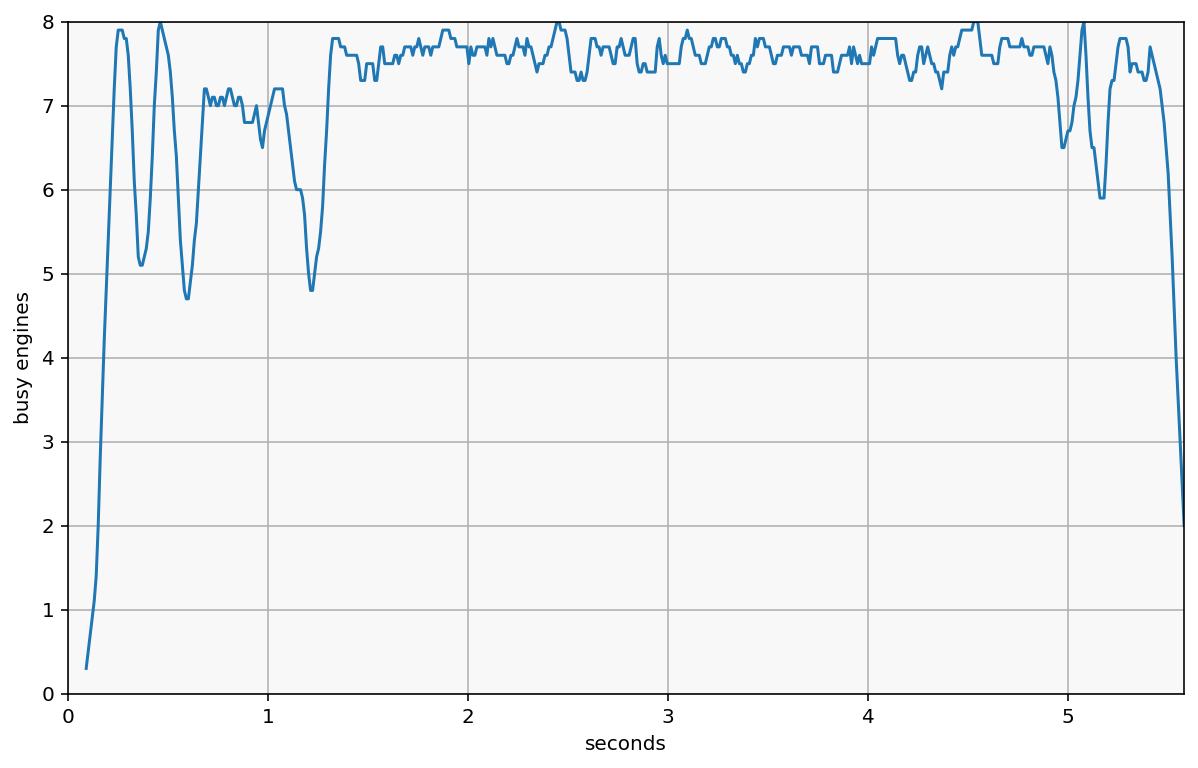

In [9]:
def plot_load(asyncresult_df, samples=None, window=10):
    if samples is None:
        samples = min(int(1e2 * df['received'].max()), 1001)

    timeline = np.linspace(0, df['received'].max(), samples)
    remaining = df
    working = []
    for t in timeline:

        remaining = remaining[remaining.completed >= t]
        active = remaining[remaining.started < t]
        working.append(len(active))

    s = pd.Series(working, index=timeline, name="load")
    if window > 1:
        windowed = s.rolling(window).mean()
    else:
        windowed = s
    windowed.plot()
    plt.ylim(0, len(df.engine_id.unique()))
    plt.xlabel("seconds")
    plt.ylabel("busy engines")
    plt.xlim(0, timeline[-1])
    
plot_load(df)